# 분석 배경

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

# Step0. Module 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

# Step1. Data Load

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape, test.shape)
train.head(2)

(8693, 14) (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [4]:
target = test['PassengerId']

# Step2. Data Info

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
print('train 중복값 : {}'.format(train.duplicated().sum()))

train 중복값 : 0


In [8]:
def summary(df):
    dfs = pd.DataFrame(data = df.dtypes, columns = ['data_type'])
    dfs['missing'] = df.isnull().sum()
    dfs['missing%'] = round(df.isnull().sum() / len(df) * 100  ,3)
    dfs['nunique'] = df.nunique()
    dfs.sort_values(by = ['data_type', 'missing%', 'nunique'], inplace = True)
    return dfs

summary(train)

,data_type,missing,missing%,nunique
Transported,bool,0,0.000,2
Age,float64,179,2.059,80
RoomService,float64,181,2.082,1273
Spa,float64,183,2.105,1327
FoodCourt,float64,183,2.105,1507
VRDeck,float64,188,2.163,1306
ShoppingMall,float64,208,2.393,1115
PassengerId,object,0,0.000,8693
Destination,object,182,2.094,3
Cabin,object,199,2.289,6560


In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [10]:
train.groupby('Transported').mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Transported,,,,,,
False,29.922858,389.266066,382.615930,167.566217,564.382666,543.629822
True,27.748834,63.098021,532.691984,179.829972,61.675531,69.148131


In [11]:
train.groupby('CryoSleep').mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
CryoSleep,,,,,,,
False,29.651319,350.146772,713.004316,270.586504,486.09294,475.716165,0.328921
True,27.405415,0.000000,0.000000,0.000000,0.00000,0.000000,0.817583


In [12]:
def numeric(df):
    return df.select_dtypes(include = np.number).columns

def categoric(df):
    return df.select_dtypes(exclude = np.number).columns

# Step3. EDA

True     4378
False    4315
Name: Transported, dtype: int64


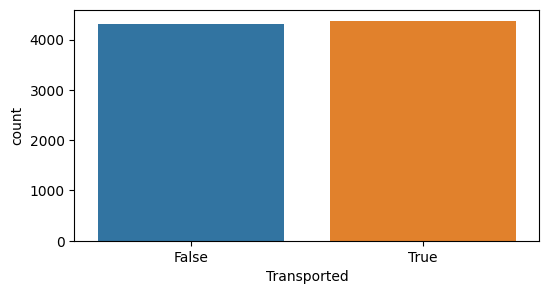

In [13]:
print(train['Transported'].value_counts())
plt.figure(figsize = (6, 3))
sns.countplot(data = train, x = 'Transported')
plt.show()

In [14]:
print(numeric(train))

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')


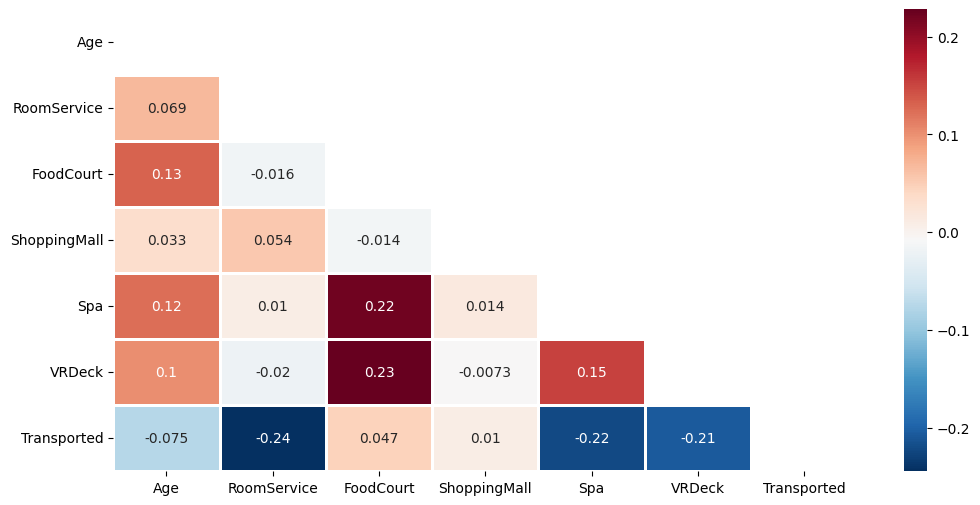

In [15]:
plt.figure(figsize = (12, 6))
train_cor = train.corr(method = 'pearson')
mask = np.zeros_like(train_cor, dtype = np.number)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data = train_cor,
           cmap = 'RdBu_r',
           linewidth = 2,
           annot = True,
           mask = mask)
plt.show()

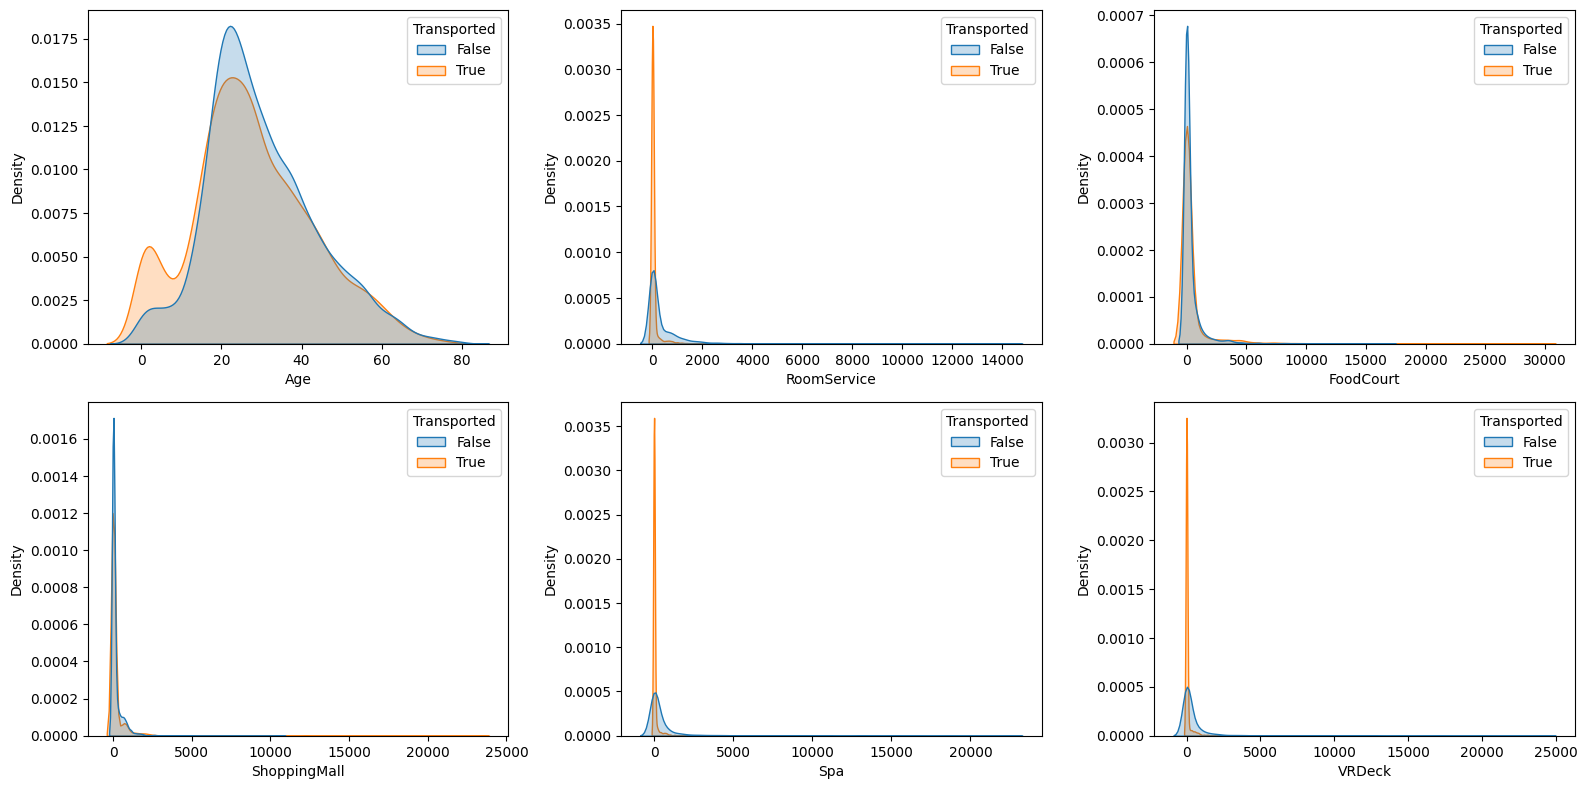

In [16]:
fig, axs = plt.subplots(2, 3, figsize = (16, 8))
for i, column in enumerate(numeric(train)):
    row, col = i // 3, i % 3
    sns.kdeplot(data = train, x = column, hue = 'Transported', fill = True, ax = axs[row, col])
    
plt.tight_layout()
plt.show()

In [17]:
print(categoric(train))

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name', 'Transported'],
      dtype='object')


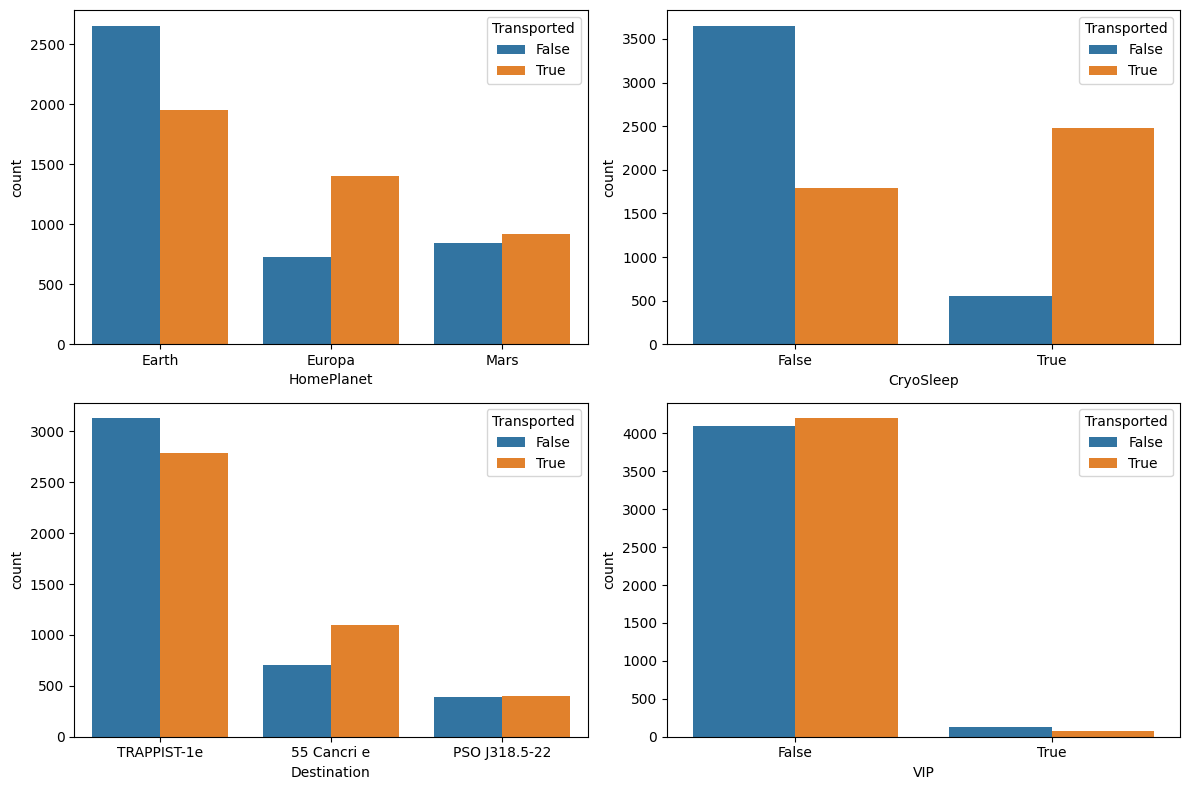

In [18]:
c = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axs = plt.subplots(2, 2, figsize = (12, 8))
for i, column in enumerate(c):
    row, col = i // 2, i % 2
    sns.countplot(data = train, x = column, order = train[column].value_counts().index, hue = 'Transported', ax = axs[row, col])
    # axs[row, col].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Step4. FE

In [19]:
numeric(train)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

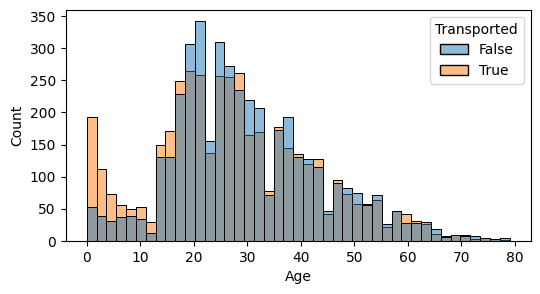

In [20]:
plt.figure(figsize = (6, 3))
sns.histplot(data = train, x = 'Age', hue = 'Transported')
plt.show()

In [21]:
def age_group(df):
    df['AgeGroup'] = np.nan
    df.loc[df['Age'] <= 18, 'AgeGroup'] = '18-'
    df.loc[(df['Age'] > 18) & (df['Age'] <= 30), 'AgeGroup'] = '18-30'
    df.loc[(df['Age'] > 30) & (df['Age'] <= 40), 'AgeGroup'] = '30-40'
    df.loc[(df['Age'] > 40) & (df['Age'] <= 50), 'AgeGroup'] = '40-50'
    df.loc[(df['Age'] > 50) & (df['Age'] <= 60), 'AgeGroup'] = '50-60'
    df.loc[(df['Age'] > 60) & (df['Age'] <= 70), 'AgeGroup'] = '60-70'
    df.loc[(df['Age'] > 70), 'AgeGroup'] = '70+'
    return 

age_group(train)
age_group(test)
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,AgeGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,30-40
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,18-30


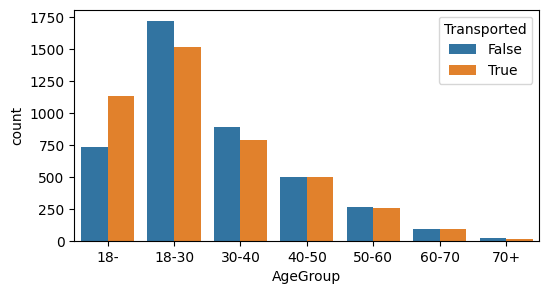

In [23]:
plt.figure(figsize = (6, 3))
sns.countplot(data = train, x = 'AgeGroup', hue = 'Transported', order = ['18-', '18-30', '30-40', '40-50', '50-60', '60-70', '70+'])
plt.show()

In [24]:
def total_spent(df):
    df['Total_Spent'] = df['RoomService'] + df['Spa'] + df['VRDeck'] + df['FoodCourt'] + df['ShoppingMall']
    df['Zero_Spent'] = (df['Total_Spent'] == 0).astype('int')

total_spent(train)
total_spent(test)
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,AgeGroup,Total_Spent,Zero_Spent
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,30-40,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,18-30,736.0,0


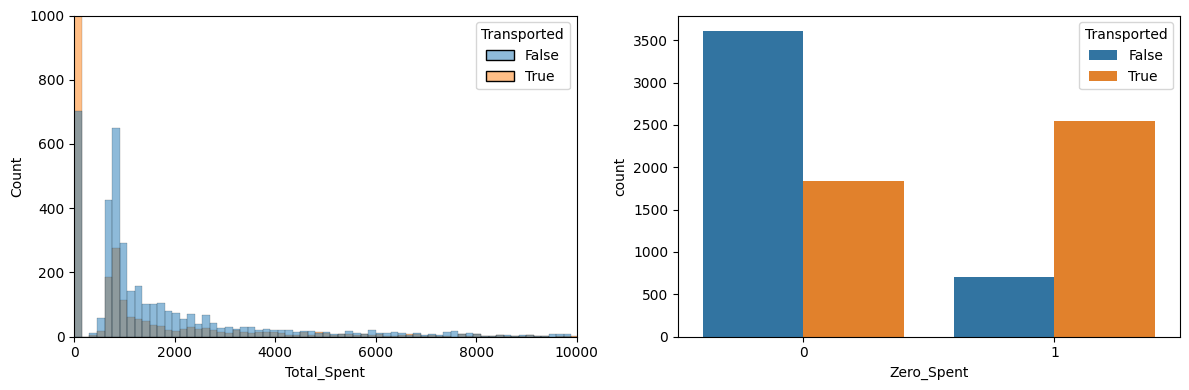

In [25]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

for i, column in enumerate(['Total_Spent', 'Zero_Spent']):
    row, col = i // 2, i % 2
    if col == 0:
        sns.histplot(data = train, x = column, hue = 'Transported', ax = axs[col])
        axs[col].set_ylim([0,1000])
        axs[col].set_xlim([0,10000])
    else:
        sns.countplot(data = train, x = column, hue = 'Transported', ax = axs[col])
        
plt.tight_layout()
plt.show()

In [26]:
categoric(train)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name', 'Transported', 'AgeGroup'],
      dtype='object')

In [27]:
def passenger_split(df):
    df['Group'] = df['PassengerId'].apply(lambda x : x.split('_')[0]).astype('int')
    df['Group_Size'] = df['Group'].apply(lambda x : df['Group'].value_counts()[x])
    df['Solo'] = (df['Group_Size'] == 1).astype('int')
    
passenger_split(train)
passenger_split(test)
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,AgeGroup,Total_Spent,Zero_Spent,Group,Group_Size,Solo
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,30-40,0.0,1,1,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,18-30,736.0,0,2,1,1


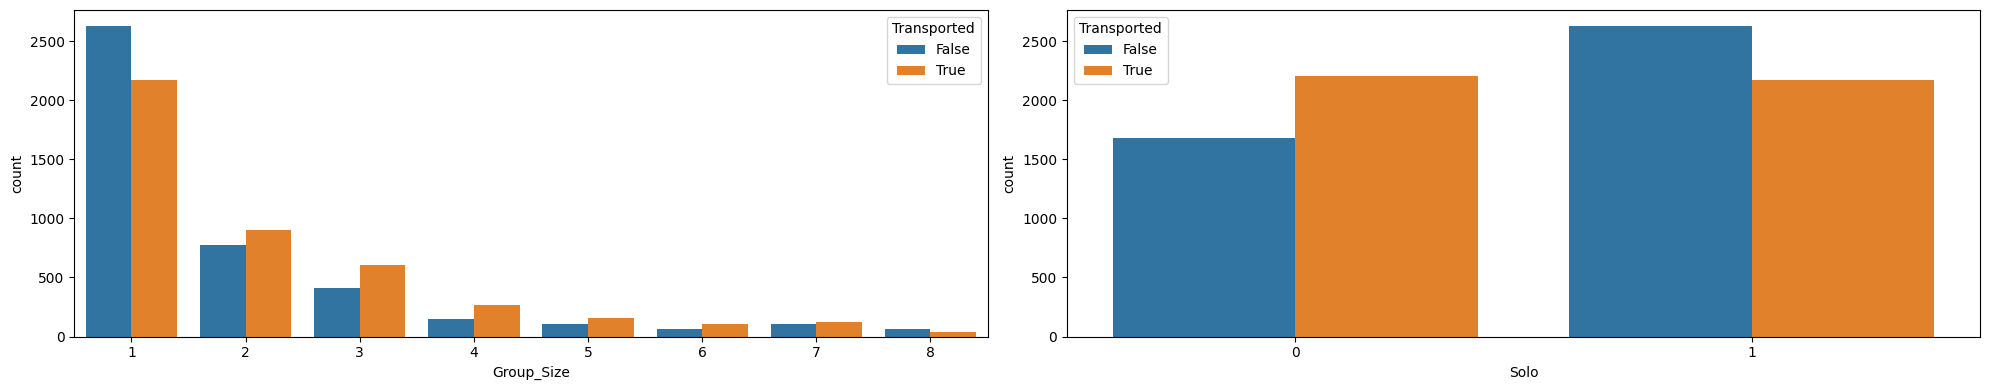

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (20, 4))

for i, column in enumerate(['Group_Size', 'Solo']):
    row, col = i // 2, i % 2
    sns.countplot(data = train, x = column, hue = 'Transported', ax = axs[col])
        
plt.tight_layout()
plt.show()

In [29]:
def cabin_split(df):
    df['Cabin'].fillna('Z/9999/Z', inplace = True)
    df[['CabinDeck','CabinNo','CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNo'] = df['CabinNo'].astype('int')

    df.loc[df['CabinDeck'] == 'Z', 'CabinDeck'] = np.nan
    df.loc[df['CabinNo'] == 9999, 'CabinNo'] = np.nan
    df.loc[df['CabinSide'] == 'Z', 'CabinSide'] = np.nan
    
    df.drop('Cabin', axis = 1, inplace = True)
    return df

cabin_split(train)
cabin_split(test)
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Transported,AgeGroup,Total_Spent,Zero_Spent,Group,Group_Size,Solo,CabinDeck,CabinNo,CabinSide
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,False,30-40,0.0,1,1,1,1,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,True,18-30,736.0,0,2,1,1,F,0.0,S


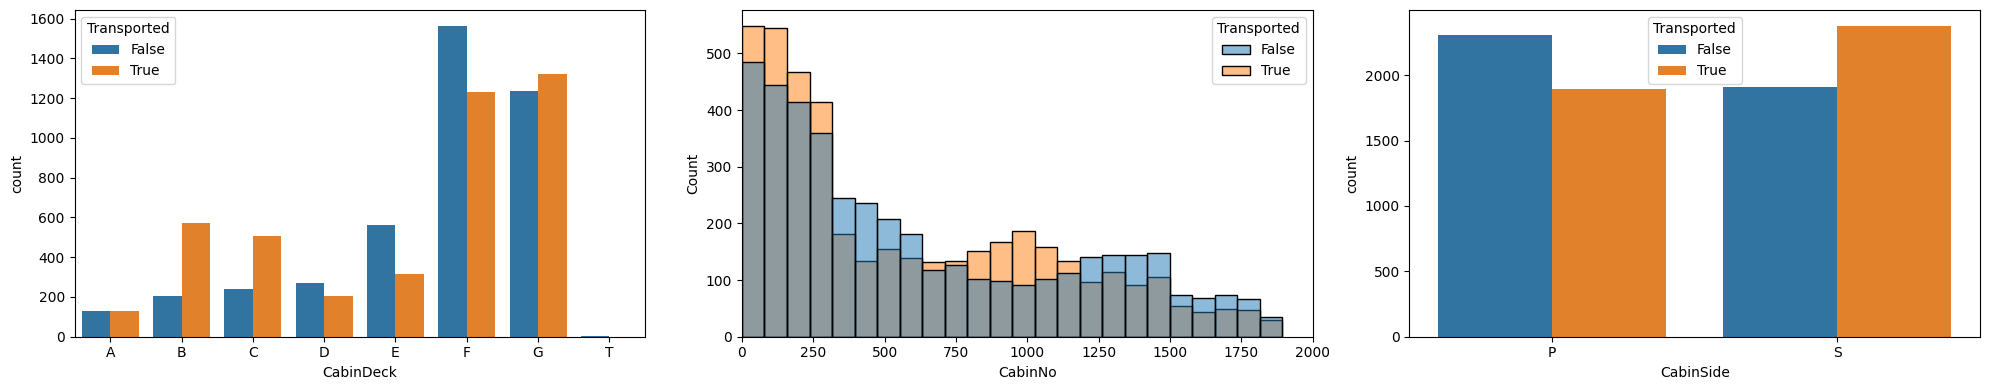

In [30]:
fig, axs = plt.subplots(1, 3, figsize = (20, 4))

for i, column in enumerate(['CabinDeck', 'CabinNo', 'CabinSide']):
    row, col = i // 3, i % 3
    if col == 0:
        sns.countplot(data = train, x = column, hue = 'Transported', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], ax = axs[col])
    elif col == 1:
        sns.histplot(data = train, x = column, hue = 'Transported', ax = axs[col])
        axs[col].set_xlim([0, 2000])
    else:
        sns.countplot(data = train, x = column, hue = 'Transported', ax = axs[col])
        
plt.tight_layout()
plt.show()

In [31]:
def cabinno_split(df):
    df['CabinNo_Group'] = 0
    df.loc[df['CabinNo'] < 300, 'CabinNo_Group'] = '3-'
    df.loc[(df['CabinNo'] >= 300) & (df['CabinNo'] < 600), 'CabinNo_Group'] = '3-6'
    df.loc[(df['CabinNo'] >= 600) & (df['CabinNo'] < 900), 'CabinNo_Group'] = '6-9'
    df.loc[(df['CabinNo'] >= 900) & (df['CabinNo'] < 1200), 'CabinNo_Group'] = '9-12'
    df.loc[(df['CabinNo'] >= 1200) & (df['CabinNo'] < 1500), 'CabinNo_Group'] = '12-15'
    df.loc[(df['CabinNo'] >= 1500) & (df['CabinNo'] < 1800), 'CabinNo_Group'] = '15-18'
    df.loc[(df['CabinNo'] >= 1800), 'CabinNo_Group'] = '18+'
    return df

cabinno_split(train)
cabinno_split(test)
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,AgeGroup,Total_Spent,Zero_Spent,Group,Group_Size,Solo,CabinDeck,CabinNo,CabinSide,CabinNo_Group
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,30-40,0.0,1,1,1,1,B,0.0,P,3-
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,18-30,736.0,0,2,1,1,F,0.0,S,3-


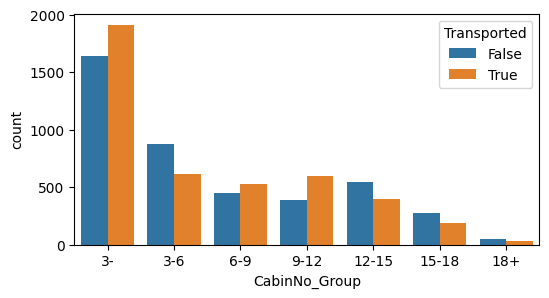

In [32]:
plt.figure(figsize = (6, 3))
sns.countplot(data = train, x = 'CabinNo_Group', hue = 'Transported', order = ['3-', '3-6', '6-9', '9-12', '12-15', '15-18', '18+'])
plt.show()

In [33]:
def name_split(df):
    df['Name'].fillna('unknown unknown', inplace = True)
    df['Surname'] = df['Name'].str.split().str[-1]
    df['Family_size'] = df['Surname'].apply(lambda x : df['Surname'].value_counts()[x])
    
    df.loc[df['Surname'] == 'unknown', 'Surname'] = np.nan
    df.loc[df['Family_size'] > 100, 'Family_size'] = np.nan
    
    df.drop('Name', axis = 1, inplace = True)
    return df

name_split(train)
name_split(test)
train.head(2)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Zero_Spent,Group,Group_Size,Solo,CabinDeck,CabinNo,CabinSide,CabinNo_Group,Surname,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,1,1,1,1,B,0.0,P,3-,Ofracculy,1.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0,2,1,1,F,0.0,S,3-,Vines,4.0


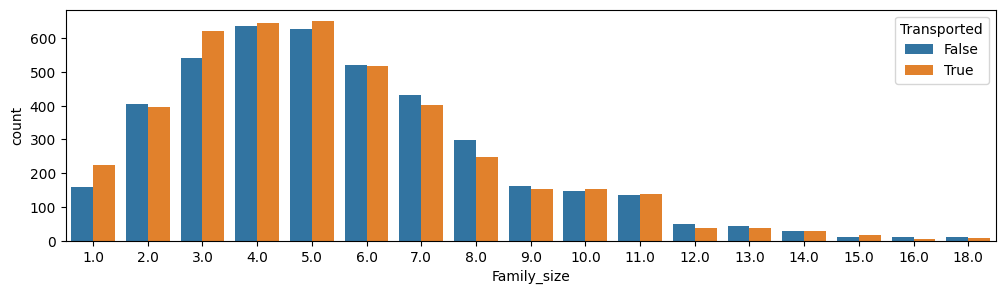

In [34]:
plt.figure(figsize = (12, 3))
sns.countplot(data = train, x = 'Family_size', hue = 'Transported')
plt.show()

In [36]:
summary(train)

,data_type,missing,missing%,nunique
Transported,bool,0,0.000,2
Zero_Spent,int32,0,0.000,2
Solo,int32,0,0.000,2
Group,int32,0,0.000,6217
Group_Size,int64,0,0.000,8
Age,float64,179,2.059,80
RoomService,float64,181,2.082,1273
Spa,float64,183,2.105,1327
FoodCourt,float64,183,2.105,1507
VRDeck,float64,188,2.163,1306


In [37]:
numeric(train)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Total_Spent', 'Zero_Spent', 'Group', 'Group_Size', 'Solo', 'CabinNo',
       'Family_size'],
      dtype='object')

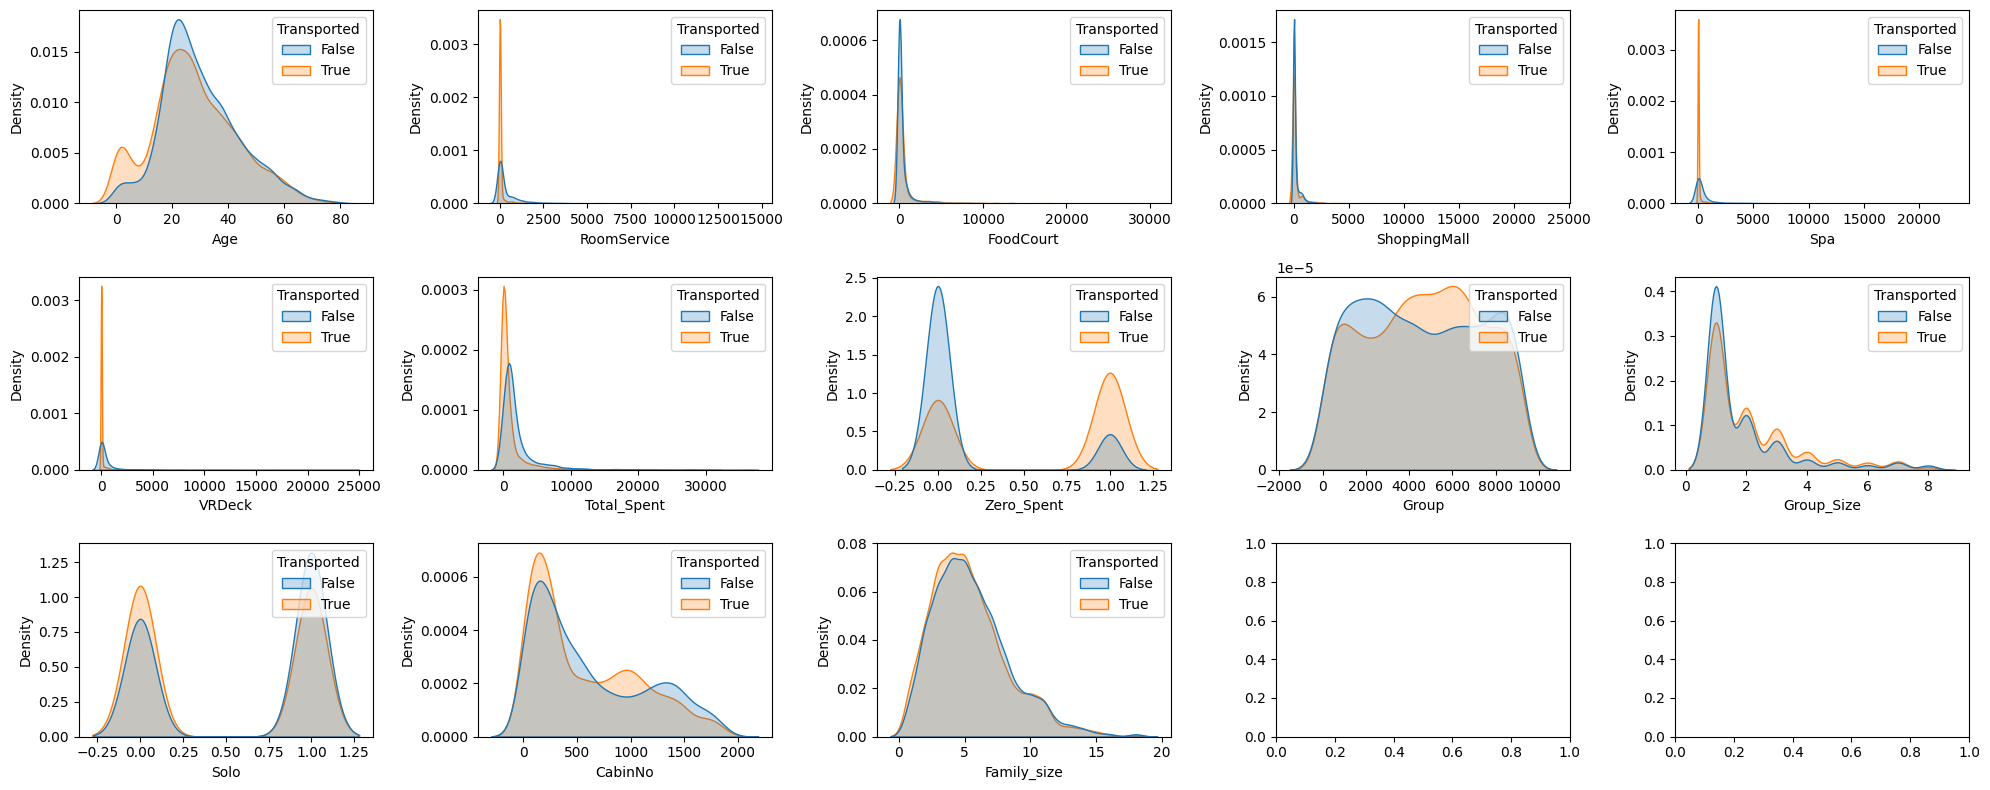

In [38]:
fig, axs = plt.subplots(3, 5, figsize = (20, 8))
for i, column in enumerate(numeric(train)):
    row, col = i // 5, i % 5
    sns.kdeplot(data = train, x = column, fill = True, hue = 'Transported', ax = axs[row, col])
    
plt.tight_layout()
plt.show()

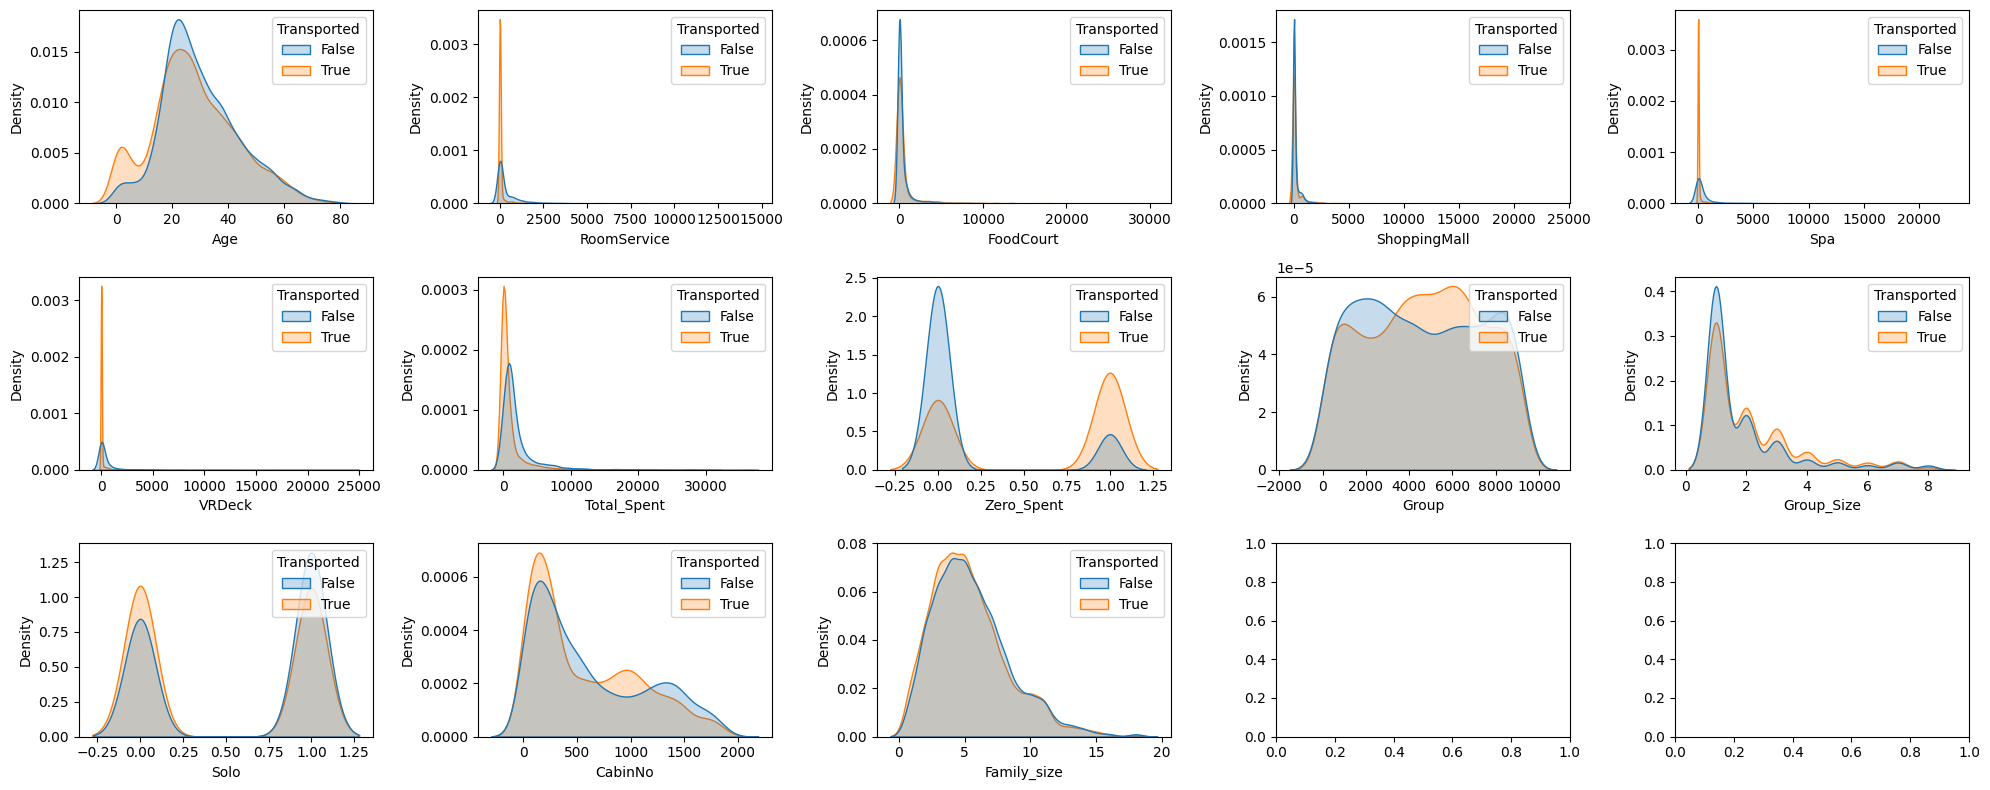

In [39]:
fig, axs = plt.subplots(3, 5, figsize = (20, 8))
for i, column in enumerate(numeric(train)):
    row, col = i // 5, i % 5
    sns.kdeplot(data = train, x = column, fill = True, hue = 'Transported', ax = axs[row, col])
    
plt.tight_layout()
plt.show()

# Step5. OutLier

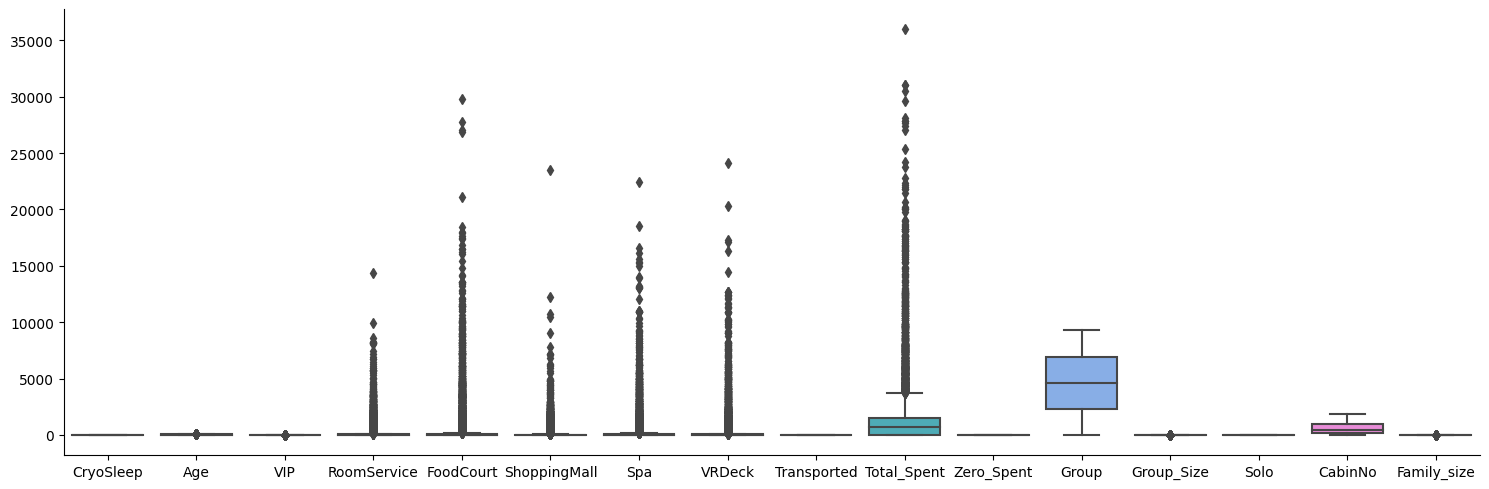

In [41]:
sns.catplot(data = train, kind = 'box', aspect = 3)
plt.show()

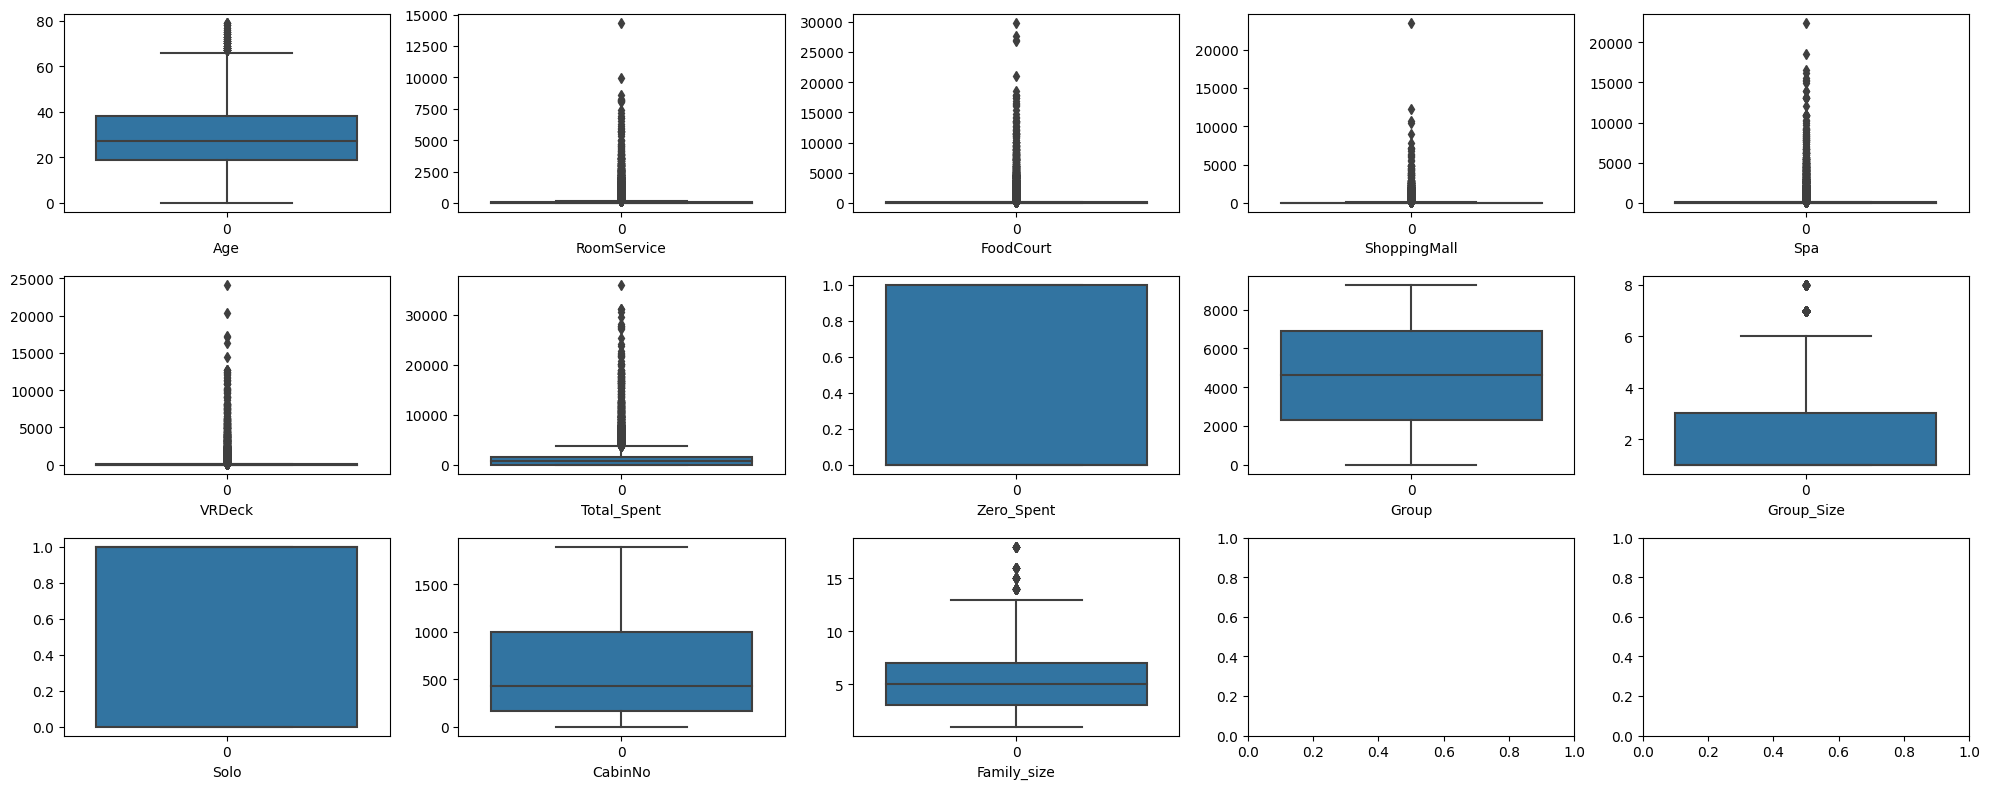

In [42]:
fig, axs = plt.subplots(3, 5, figsize = (20, 8))
for i, column in enumerate(numeric(train)):
    row, col = i // 5, i % 5
    sns.boxplot(data = train[column], ax = axs[row, col])
    axs[row,col].set_xlabel(column)

plt.tight_layout()
plt.show()

# Step6. Imputation

In [45]:
def before_null(df):
    return df.isnull().sum()

def after_null(df):
    return df.isnull().sum()

def null_result(before, after):
    return print('Before {} -> After {}'.format(before, after))

In [46]:
summary(train[categoric(train)])

,data_type,missing,missing%,nunique
Transported,bool,0,0.000,2
CabinNo_Group,object,0,0.000,8
PassengerId,object,0,0.000,8693
AgeGroup,object,179,2.059,7
Destination,object,182,2.094,3
CabinSide,object,199,2.289,2
CabinDeck,object,199,2.289,8
Surname,object,200,2.301,2217
HomePlanet,object,201,2.312,3
VIP,object,203,2.335,2


In [47]:
def homeplanet_group_nan_fill(df):
    before = before_null(df['HomePlanet'])
    
    hp_gp = df.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
    hp_gp_idx = df[df['HomePlanet'].isnull()][df[df['HomePlanet'].isnull()]['Group'].isin(hp_gp.index)].index
    df.loc[hp_gp_idx, 'HomePlanet'] = df.iloc[hp_gp_idx, :]['Group'].apply(lambda x : hp_gp.idxmax(axis = 1)[x])

    after = after_null(df['HomePlanet'])
    null_result(before, after)
    return 

homeplanet_group_nan_fill(train)
homeplanet_group_nan_fill(test)

Before 201 -> After 111
Before 87 -> After 46


In [48]:
def homeplanet_surname_nan_fill(df):
    before = before_null(df['HomePlanet'])
    
    hp_sn = df.groupby(['Surname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
    hp_sn_idx = df[df['HomePlanet'].isnull()][df[df['HomePlanet'].isnull()]['Surname'].isin(hp_sn.index)].index
    df.loc[hp_sn_idx, 'HomePlanet'] = df.iloc[hp_sn_idx, :]['Surname'].apply(lambda x : hp_sn.idxmax(axis = 1)[x])
    
    after = after_null(df['HomePlanet'])
    null_result(before, after)
    return 

homeplanet_surname_nan_fill(train)
homeplanet_surname_nan_fill(test)

Before 111 -> After 12
Before 46 -> After 16


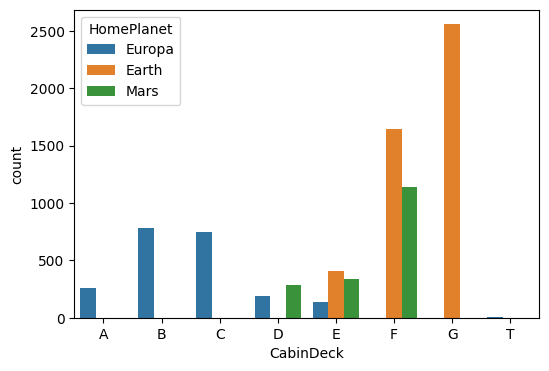

In [49]:
plt.figure(figsize = (6, 4))
sns.countplot(data = train, x = 'CabinDeck', hue = 'HomePlanet', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.show()

In [50]:
def homeplanet_cabindeck_nan_fill(df):
    before = before_null(df['HomePlanet'])
    
    df.loc[df['HomePlanet'].isnull() & df['CabinDeck'].isin(['A', 'B', 'C', 'T']), 'HomePlanet'] = 'Europa'
    df.loc[df['HomePlanet'].isnull() & df['CabinDeck'].isin(['G']), 'HomePlanet'] = 'Earth'
    df.loc[df['HomePlanet'].isnull() & df['CabinDeck'].isin(['E', 'F']), 'HomePlanet'] = 'Earth'
    df.loc[df['HomePlanet'].isnull() & df['CabinDeck'].isin(['D']), 'HomePlanet'] = 'Mars'
    
    after = after_null(df['HomePlanet'])
    null_result(before, after)
    return 

homeplanet_cabindeck_nan_fill(train)
homeplanet_cabindeck_nan_fill(test)

Before 12 -> After 0
Before 16 -> After 0


In [51]:
def destination_nan_fill(df):
    before = before_null(df['Destination'])

    df.loc[df['Destination'].isnull(), 'Destination'] = 'TRAPPIST-1e'

    after = after_null(df['Destination'])
    null_result(before, after)

destination_nan_fill(train)
destination_nan_fill(test)

Before 182 -> After 0
Before 92 -> After 0


In [52]:
def vip_nan_fill(df):
    before = before_null(df['VIP'])

    df.loc[df['VIP'].isnull(), 'VIP'] = False

    after = after_null(df['VIP'])
    null_result(before, after)

vip_nan_fill(train)
vip_nan_fill(test)

Before 203 -> After 0
Before 93 -> After 0


In [53]:
def surname_group_nan_fill(df):
    before = before_null(df['Surname'])
    
    sn_gp = df[df['Group_Size'] > 1].groupby(['Group', 'Surname'])['Surname'].size().unstack().fillna(0)
    sn_gp_idx = df[df['Surname'].isnull()][df[df['Surname'].isnull()]['Group'].isin(sn_gp.index)].index
    df.loc[sn_gp_idx, 'Surname'] = df.iloc[sn_gp_idx, : ]['Group'].apply(lambda x : sn_gp.idxmax(axis = 1)[x])

    after = after_null(df['Surname'])
    null_result(before, after)
    return 

surname_group_nan_fill(train)
surname_group_nan_fill(test)

Before 200 -> After 104
Before 94 -> After 51


In [54]:
def family_size_nan_fill(df):
    before = before_null(df['Family_size'])
    
    df['Surname'].fillna('unknown', inplace=True)
    df['Family_size'] = df['Surname'].apply(lambda x: df['Surname'].value_counts()[x])
    df.loc[df['Surname'] =='unknown', 'Surname'] = np.nan
    df.loc[df['Family_size'] > 100, 'Family_size'] = 0
    
    after = after_null(df['Family_size'])
    null_result(before, after)
    return 

family_size_nan_fill(train)
family_size_nan_fill(test)

Before 200 -> After 0
Before 0 -> After 0


In [55]:
def cryosleep_zs_nan_fill(df):
    before = before_null(df['CryoSleep'])

    cs_zs = df.groupby(['Zero_Spent', 'CryoSleep'])['CryoSleep'].size().unstack().fillna(0)
    cs_zs_idx = df[df['CryoSleep'].isnull()][df[df['CryoSleep'].isnull()]['Zero_Spent'].isin(cs_zs.index)].index
    df.loc[cs_zs_idx, 'CryoSleep'] = df.iloc[cs_zs_idx, : ]['Zero_Spent'].apply(lambda x : cs_zs.idxmax(axis = 1)[x])

    after = after_null(df['CryoSleep'])
    null_result(before, after)
    return 

cryosleep_zs_nan_fill(train)
cryosleep_zs_nan_fill(test)

Before 217 -> After 0
Before 93 -> After 0


In [56]:
def cabinside_group_nan_fill(df):
    before = before_null(df['CabinSide'])

    cs_gp = df.groupby(['Group', 'CabinSide'])['CabinSide'].size().unstack().fillna(0)
    cs_gp_idx = df[df['CabinSide'].isnull()][df[df['CabinSide'].isnull()]['Group'].isin(cs_gp.index)].index
    df.loc[cs_gp_idx, 'CabinSide'] = df.iloc[cs_gp_idx, :]['Group'].apply(lambda x : cs_gp.idxmax(axis = 1)[x])

    after = after_null(df['CabinSide'])
    null_result(before, after)
    return

cabinside_group_nan_fill(train)
cabinside_group_nan_fill(test)

Before 199 -> After 99
Before 100 -> After 63


In [57]:
def cabinside_surname_nan_fill(df):
    before = before_null(df['CabinSide'])

    cs_sn = df.groupby(['Surname', 'CabinSide'])['CabinSide'].size().unstack().fillna(0)
    cs_sn_idx = df[df['CabinSide'].isnull()][df[df['CabinSide'].isnull()]['Surname'].isin(cs_sn.index)].index
    df.loc[cs_sn_idx, 'CabinSide'] = df.iloc[cs_sn_idx, :]['Surname'].apply(lambda x : cs_sn.idxmax(axis = 1)[x])

    after = after_null(df['CabinSide'])
    null_result(before, after)
    return

cabinside_surname_nan_fill(train)
cabinside_surname_nan_fill(test)

Before 99 -> After 9
Before 63 -> After 17


In [58]:
def cabinside_fill_all(df):
    before = before_null(df['CabinSide'])
    df.loc[df['CabinSide'].isnull(), 'CabinSide'] = df['CabinSide'].mode()[0]

    after = after_null(df['CabinSide'])
    null_result(before, after)
    return

cabinside_fill_all(train)
cabinside_fill_all(test)

Before 9 -> After 0
Before 17 -> After 0


In [59]:
def cabindeck_group_nan_fill(df):
    before = before_null(df['CabinDeck'])

    cd_gp = df.groupby(['Group', 'CabinDeck'])['CabinDeck'].size().unstack().fillna(0)
    cd_gp_idx = df[df['CabinDeck'].isnull()][df[df['CabinDeck'].isnull()]['Group'].isin(cd_gp.index)].index
    df.loc[cd_gp_idx, 'CabinDeck'] = df.iloc[cd_gp_idx, :]['Group'].apply(lambda x : cd_gp.idxmax(axis = 1)[x])

    after = after_null(df['CabinDeck'])
    null_result(before, after)
    return

cabindeck_group_nan_fill(train)
cabindeck_group_nan_fill(test)

Before 199 -> After 99
Before 100 -> After 63


In [60]:
def cabindeck_fill_all(df):
    before = before_null(df['CabinDeck'])

    cd = df.groupby(['HomePlanet','Destination','CabinDeck'])['CabinDeck'].size().unstack().fillna(0)
    cd_idx = df[df['CabinDeck'].isnull()].index
    df.loc[df['CabinDeck'].isnull(), 'CabinDeck'] = df.groupby(['HomePlanet','Destination'])['CabinDeck'].transform(lambda x : x.fillna(pd.Series.mode(x)[0]))[cd_idx]

    after = after_null(df['CabinDeck'])
    null_result(before, after)
    return 

cabindeck_fill_all(train)
cabindeck_fill_all(test)

Before 99 -> After 0
Before 63 -> After 0


In [61]:
def age_fill_all(df):
    before = before_null(df['Age'])

    df.loc[df['Age'].isnull(), 'Age'] = df['Age'].mean()

    after = after_null(df['Age'])
    null_result(before, after)
    return 

age_fill_all(train)
age_fill_all(test)

Before 179 -> After 0
Before 91 -> After 0


In [62]:
def age_group_renew(df):
    before = before_null(df['AgeGroup'])
    
    df['AgeGroup'] = np.nan
    df.loc[df['Age'] <= 18, 'AgeGroup'] = '18-'
    df.loc[(df['Age'] > 18) & (df['Age'] <= 30), 'AgeGroup'] = '18-30'
    df.loc[(df['Age'] > 30) & (df['Age'] <= 40), 'AgeGroup'] = '30-40'
    df.loc[(df['Age'] > 40) & (df['Age'] <= 50), 'AgeGroup'] = '40-50'
    df.loc[(df['Age'] > 50) & (df['Age'] <= 60), 'AgeGroup'] = '50-60'
    df.loc[(df['Age'] > 60) & (df['Age'] <= 70), 'AgeGroup'] = '60-70'
    df.loc[(df['Age'] > 70), 'AgeGroup'] = '70+'
    
    after = after_null(df['AgeGroup'])
    null_result(before, after)
    return 

age_group_renew(train)
age_group_renew(test)

Before 179 -> After 0
Before 91 -> After 0


In [63]:
def numeric_fill_all(df):
    column =  ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck', 'Total_Spent']
    for c in column:
        df.loc[df[c].isnull() & df['CryoSleep'] == True, c] = 0
        
    for c in column:
        num = df.groupby(['AgeGroup', 'Solo'])[c].mean().unstack().fillna(0)
        num_idx = df.loc[df[c].isnull()].index
        df.loc[df[c].isnull(), c] = df.groupby(['AgeGroup', 'Solo'])[c].transform(lambda x : x.fillna(x.mean()))[num_idx]

    return 
numeric_fill_all(train)
numeric_fill_all(test)

In [64]:
def cabinno_fill_all(df):
    before = before_null(df['AgeGroup'])
    
    df['CabinNo'].fillna(0, inplace = True)
    
    after = after_null(df['AgeGroup'])
    null_result(before, after)
    return

cabinno_fill_all(train)
cabinno_fill_all(test)

Before 0 -> After 0
Before 0 -> After 0


In [65]:
summary(train)

,data_type,missing,missing%,nunique
Transported,bool,0,0.000,2
Zero_Spent,int32,0,0.000,2
Solo,int32,0,0.000,2
Group,int32,0,0.000,6217
Group_Size,int64,0,0.000,8
Family_size,int64,0,0.000,18
Age,float64,0,0.000,81
ShoppingMall,float64,0,0.000,1126
RoomService,float64,0,0.000,1284
VRDeck,float64,0,0.000,1318


In [66]:
def drop_column(df):
    df.drop(['PassengerId', 'Surname'], axis = 1, inplace = True)
    return

drop_column(train)
drop_column(test)

# Step7. Dummies

In [67]:
categoric(train)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported',
       'AgeGroup', 'CabinDeck', 'CabinSide', 'CabinNo_Group'],
      dtype='object')

In [68]:
train = pd.get_dummies(data = train, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP','CabinDeck', 'CabinSide', 'AgeGroup', 'CabinNo_Group'], drop_first = True)
test = pd.get_dummies(data = test, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP','CabinDeck', 'CabinSide', 'AgeGroup', 'CabinNo_Group'], drop_first = True)
train.head(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_Spent,Zero_Spent,Group,...,AgeGroup_50-60,AgeGroup_60-70,AgeGroup_70+,CabinNo_Group_12-15,CabinNo_Group_15-18,CabinNo_Group_18+,CabinNo_Group_3-,CabinNo_Group_3-6,CabinNo_Group_6-9,CabinNo_Group_9-12
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1,1,...,0,0,0,0,0,0,1,0,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,736.0,0,2,...,0,0,0,0,0,0,1,0,0,0


# Step8. Scaler

In [69]:
from sklearn.preprocessing import StandardScaler

col = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Total_Spent']

scaler = StandardScaler()
train[col] = scaler.fit_transform(train[col])
test[col] = scaler.transform(test[col])

train.head(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_Spent,Zero_Spent,Group,...,AgeGroup_50-60,AgeGroup_60-70,AgeGroup_70+,CabinNo_Group_12-15,CabinNo_Group_15-18,CabinNo_Group_18+,CabinNo_Group_3-,CabinNo_Group_3-6,CabinNo_Group_6-9,CabinNo_Group_9-12
0,0.709437,-0.337848,-0.284787,-0.287482,-0.274754,-0.266527,False,-0.524055,1,1,...,0,0,0,0,0,0,1,0,0,0
1,-0.336717,-0.172701,-0.279144,-0.245654,0.213135,-0.227713,True,-0.252716,0,2,...,0,0,0,0,0,0,1,0,0,0


# Step9. Correlation

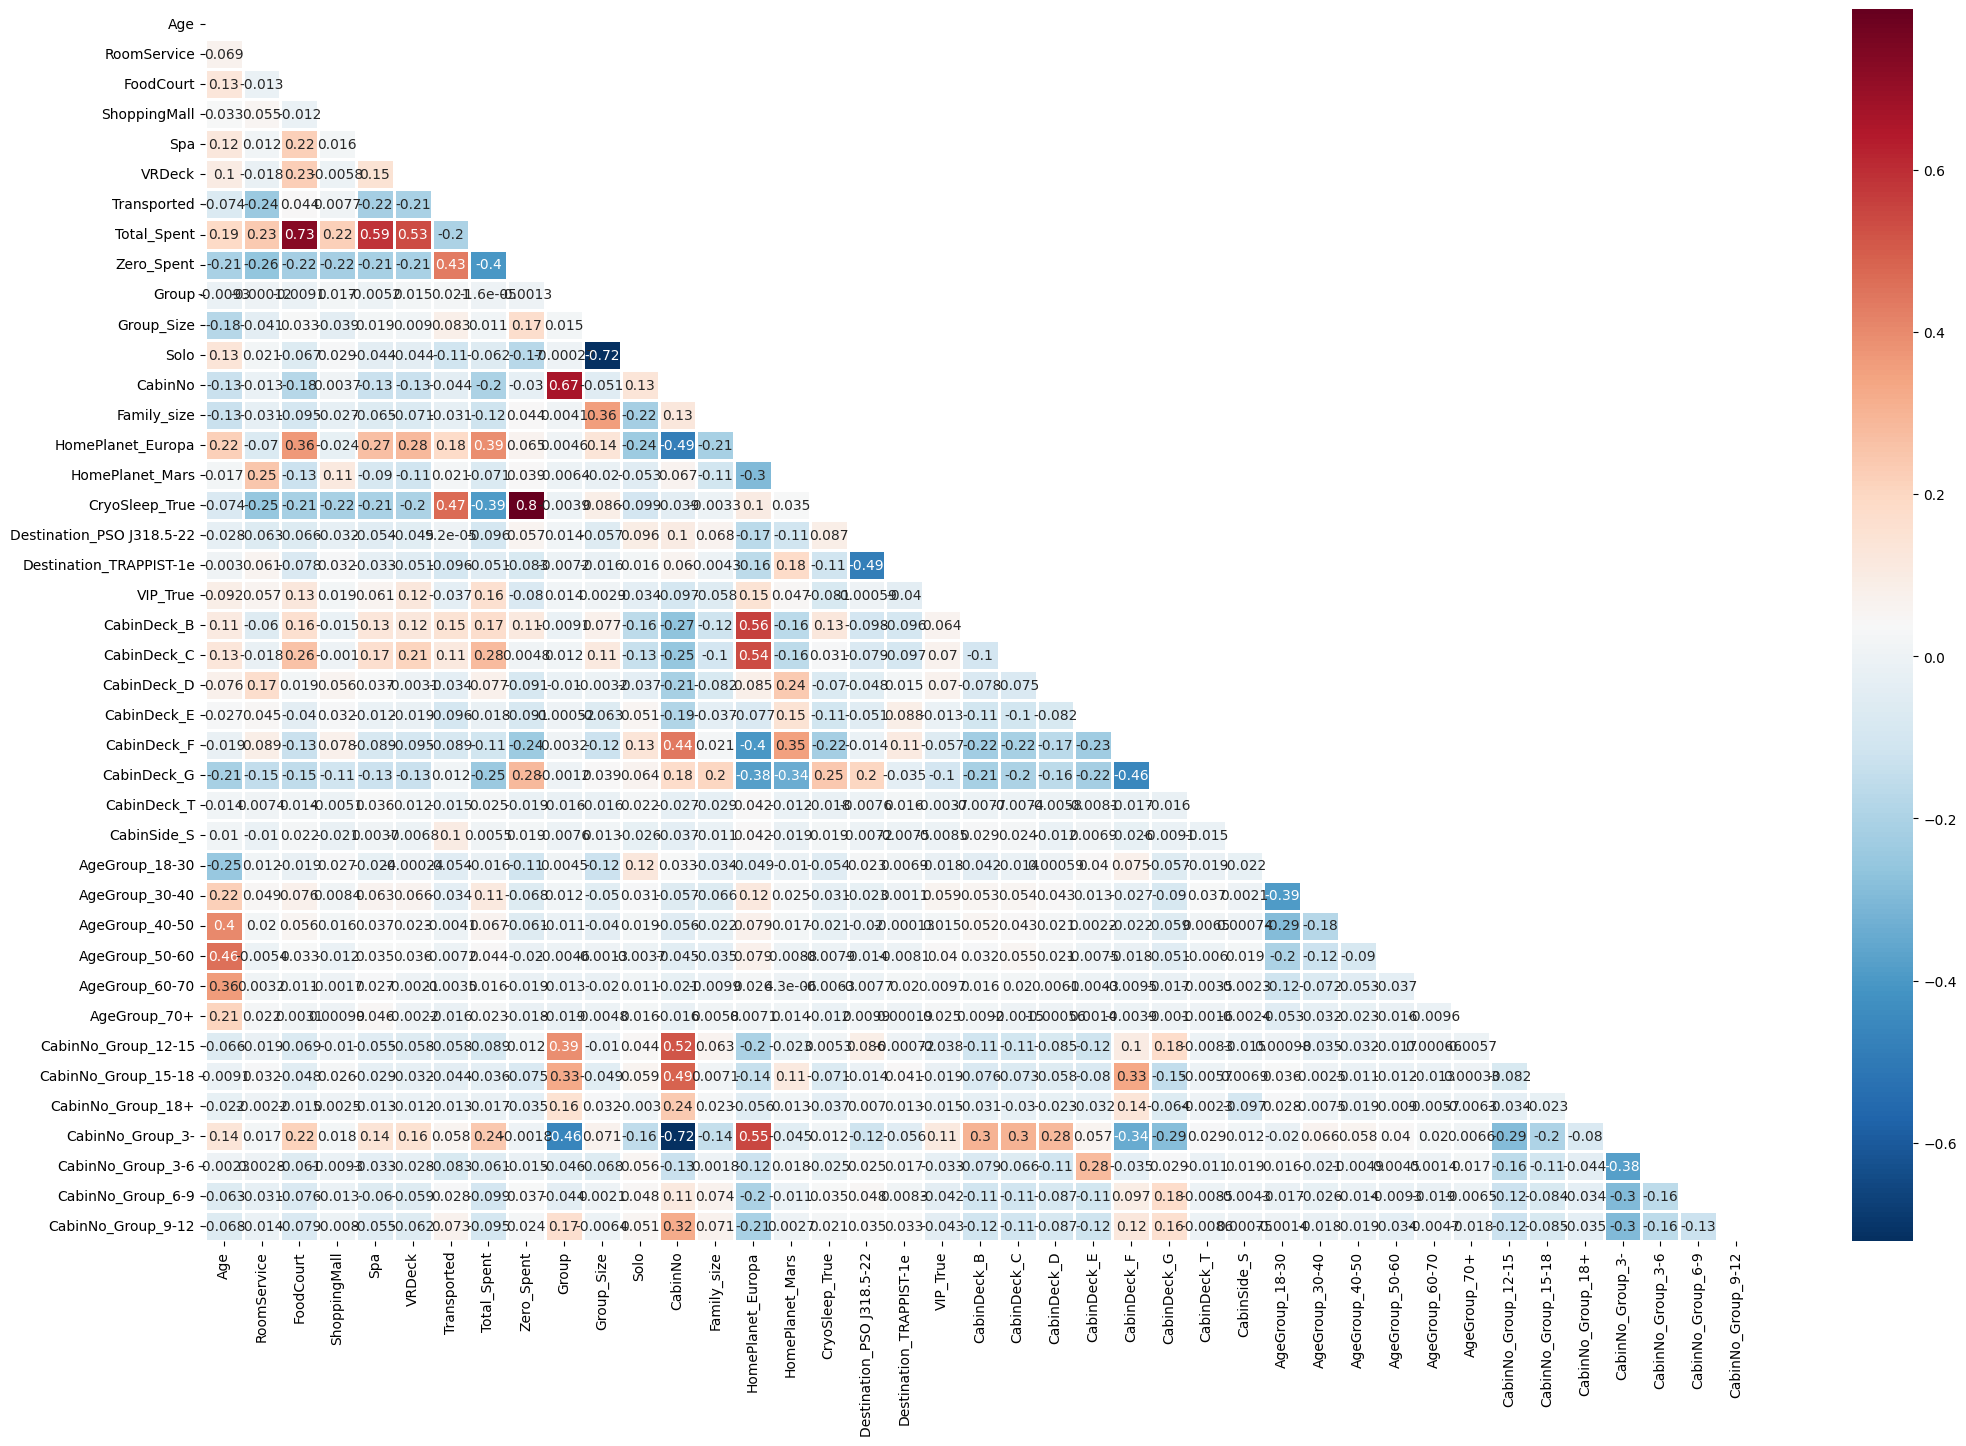

In [71]:
plt.figure(figsize = (25, 16))
train_cor = train.corr(method = 'pearson')
mask = np.zeros_like(train_cor, dtype = np.number)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data = train_cor,
           cmap = 'RdBu_r',
           linewidth = 2,
           annot = True,
           mask = mask)
plt.show()

In [72]:
from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations

def corr_check(df):
    num_feat = numeric(df)
    comb_num_feat = np.array(list(combinations(num_feat, 2)))
    corr_num_feat = np.array([])
    for comb in comb_num_feat:
        corr = pearsonr(df[comb[0]], df[comb[1]])[0]
        corr_num_feat = np.append(corr_num_feat, corr)
        
    high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
    return high_corr_num

In [73]:
print(corr_check(train))
print(corr_check(test))

[]
[]


# Step10. Prepare Modeling Data

In [75]:
df_train = train.copy()
df_test = test.copy()
X_test = test.copy()